In [10]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# Define dataset paths
DATA_DIR = "datasets_img"  # Main directory for organized data
LSBGs_DIR = "LSBGs"  # Positive class folder
NEG_DIR = "neg_typ_2"  # Negative class folder

In [2]:

def plot_sample_images(folder_path, title, num_samples=5):
    """
    Plots a specified number of sample images from a given folder.
    
    Args:
        folder_path (str): Path to the folder containing images.
        num_samples (int): Number of images to randomly sample and display.
    """
    if not os.path.exists(folder_path):
        print(f"Error: The folder '{folder_path}' does not exist.")
        return

    # Get all image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No image files found in '{folder_path}'.")
        return

    # Randomly select `num_samples` images (or all if fewer exist)
    selected_files = random.sample(image_files, min(len(image_files), num_samples))

    # Plot images
    fig, axes = plt.subplots(1, len(selected_files), figsize=(12, 3))
    fig.suptitle(title, fontsize=16)

    if len(selected_files) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only 1 image

    for ax, img_name in zip(axes, selected_files):
        img_path = os.path.join(folder_path, img_name)
        image = Image.open(img_path)

        # Convert grayscale images to RGB (for consistency)
        image = image.convert("RGB")

        ax.imshow(image)
        ax.axis("off")
        ax.set_title(img_name[:10] + "...")  # Show truncated filename

    plt.tight_layout()
    plt.show()


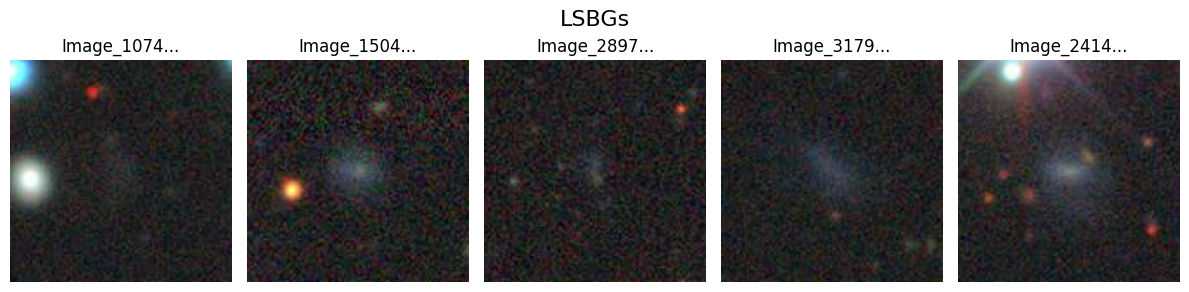

In [3]:
plot_sample_images(os.path.join(DATA_DIR, LSBGs_DIR), 'LSBGs', 5)

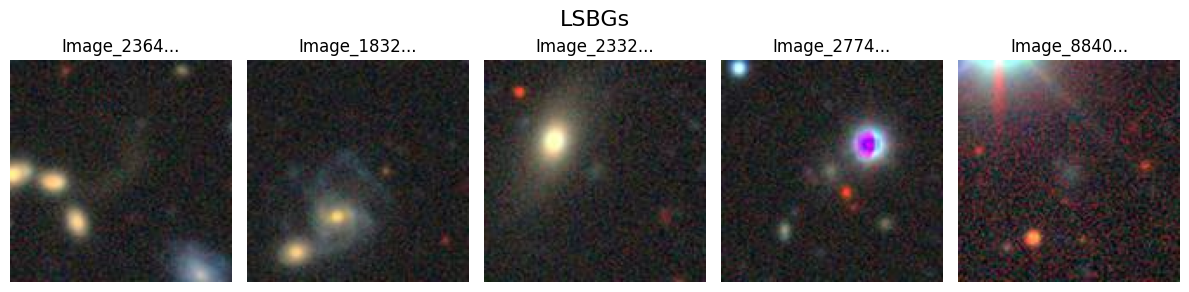

In [4]:
plot_sample_images(os.path.join(DATA_DIR, NEG_DIR), 'LSBGs', 5)

In [7]:
import os
import shutil
import random
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define splits (Train: 80%, Val: 10%, Test: 10%)
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Set random seed for reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# Create organized dataset structure if not exists
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(DATA_DIR, split, "LSBGs"), exist_ok=True)
    os.makedirs(os.path.join(DATA_DIR, split, "neg_typ_2"), exist_ok=True)

def split_and_copy_images(class_dir, class_name):
    """
    Splits images into train, val, and test folders while preserving binary classification labels.
    """
    image_files = [f for f in os.listdir(class_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_files)  # Shuffle before splitting

    # Split sizes
    train_size = int(len(image_files) * TRAIN_RATIO)
    val_size = int(len(image_files) * VAL_RATIO)
    test_size = len(image_files) - train_size - val_size  # Remaining for test

    # Assign images to each set
    train_files = image_files[:train_size]
    val_files = image_files[train_size:train_size + val_size]
    test_files = image_files[train_size + val_size:]

    # Copy files to new dataset structure
    for file, split in zip([train_files, val_files, test_files], ["train", "val", "test"]):
        for img in file:
            src = os.path.join(class_dir, img)
            dst = os.path.join(DATA_DIR, split, class_name, img)
            shutil.copy(src, dst)

    print(f"Processed {class_name}: Train={len(train_files)}, Val={len(val_files)}, Test={len(test_files)}")

# Split and copy images
split_and_copy_images(os.path.join(DATA_DIR, LSBGs_DIR), "LSBGs")
split_and_copy_images(os.path.join(DATA_DIR, NEG_DIR), "neg_typ_2")

# Define transformations (resizing, normalization for pre-trained models)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Resize for ResNet, EfficientNet, etc.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

# Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform)
val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "val"), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform)

# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Print dataset sizes
print(f"Train: {len(train_dataset)} images")
print(f"Val: {len(val_dataset)} images")
print(f"Test: {len(test_dataset)} images")

# Print class mapping (should be {'LSBGs': 0, 'neg_typ_2': 1})
print("Class Mapping:", train_dataset.class_to_idx)


Processed LSBGs: Train=7428, Val=928, Test=930
Processed neg_typ_2: Train=6952, Val=869, Test=870
Train: 14380 images
Val: 1797 images
Test: 1800 images
Class Mapping: {'LSBGs': 0, 'neg_typ_2': 1}


Using device: cuda

Epoch 1/10
Train Loss: 0.2892, Train Accuracy: 88.15%
Val Loss: 0.2692, Val Accuracy: 89.15%
✅ Best model saved!

Epoch 2/10
Train Loss: 0.1997, Train Accuracy: 92.44%
Val Loss: 0.2362, Val Accuracy: 90.65%
✅ Best model saved!

Epoch 3/10
Train Loss: 0.1515, Train Accuracy: 94.24%
Val Loss: 0.2598, Val Accuracy: 89.26%

Epoch 4/10
Train Loss: 0.1021, Train Accuracy: 96.17%
Val Loss: 0.3005, Val Accuracy: 89.87%

Epoch 5/10
Train Loss: 0.0697, Train Accuracy: 97.67%
Val Loss: 0.3300, Val Accuracy: 89.76%

Epoch 6/10
Train Loss: 0.0571, Train Accuracy: 98.11%
Val Loss: 0.3300, Val Accuracy: 88.37%

Epoch 7/10
Train Loss: 0.0416, Train Accuracy: 98.52%
Val Loss: 0.3761, Val Accuracy: 89.37%

Epoch 8/10
Train Loss: 0.0334, Train Accuracy: 98.78%
Val Loss: 0.4680, Val Accuracy: 89.54%

Epoch 9/10
Train Loss: 0.0455, Train Accuracy: 98.07%
Val Loss: 0.5535, Val Accuracy: 88.20%

Epoch 10/10
Train Loss: 0.0397, Train Accuracy: 98.48%
Val Loss: 0.5061, Val Accuracy: 89.09%


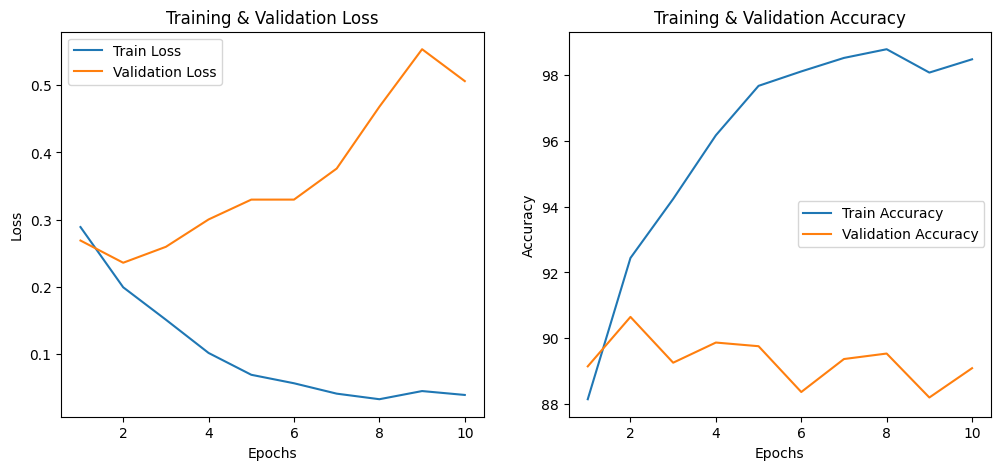

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import os

# 🔹 Use CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 🔹 Define dataset directory
#DATA_DIR = "dataset"

# 🔹 Define image transformations (NO AUGMENTATIONS)
transform = {
    "train": transforms.Compose([
        transforms.Resize((128, 128)),  # Keep images at 128x128
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Normalization
    ]),
    "val": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# 🔹 Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "train"), transform=transform["train"])
val_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "val"), transform=transform["val"])

# 🔹 Define DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# 🔹 Load Pretrained ResNet Model
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# 🔹 Modify First Convolution Layer (from 224x224 → 128x128 input)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)

# 🔹 Modify Fully Connected (FC) Layer for Binary Classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Two classes: LSBGs (1) and neg_typ_2 (0)

# 🔹 Move model to CUDA
model = model.to(device)

# 🔹 Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 🔹 Training Function
# Modify train function to track metrics
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_val_loss = float("inf")
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # Save Best Model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model_finetuned.pth")
            print("✅ Best model saved!")

    # Plot loss and accuracy curves
    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

# Function to plot training curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Accuracy")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.show()


# 🔹 Train Model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


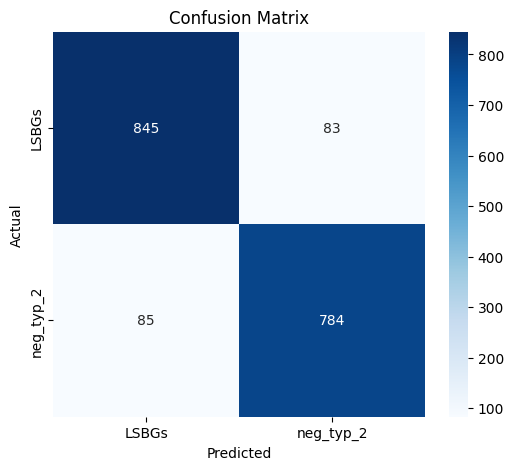

Classification Report:
               precision    recall  f1-score   support

       LSBGs       0.91      0.91      0.91       928
   neg_typ_2       0.90      0.90      0.90       869

    accuracy                           0.91      1797
   macro avg       0.91      0.91      0.91      1797
weighted avg       0.91      0.91      0.91      1797



In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load trained model
model.load_state_dict(torch.load("best_model_finetuned.pth"))
model = model.to(device)
model.eval()

# Function to evaluate model and plot confusion matrix
def evaluate_model(model, dataloader):
    y_true = []
    y_pred = []

    # Disable gradients for inference
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Store true labels and predictions
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    class_names = ["LSBGs", "neg_typ_2"]

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

# Run evaluation
evaluate_model(model, val_loader)


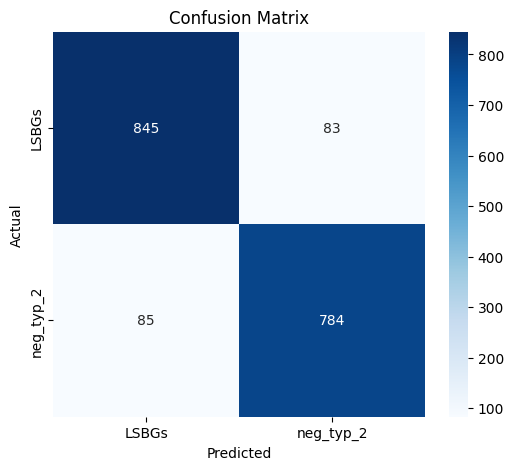

Classification Report:
               precision    recall  f1-score   support

       LSBGs       0.91      0.91      0.91       928
   neg_typ_2       0.90      0.90      0.90       869

    accuracy                           0.91      1797
   macro avg       0.91      0.91      0.91      1797
weighted avg       0.91      0.91      0.91      1797



In [14]:
evaluate_model(model, val_loader)

In [16]:
transform = {
    "train": transforms.Compose([
        transforms.Resize((128, 128)),  # Keep images at 128x128
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet Normalization
    ]),
    "val": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
        "test": transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [17]:
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, "test"), transform=transform["test"])

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

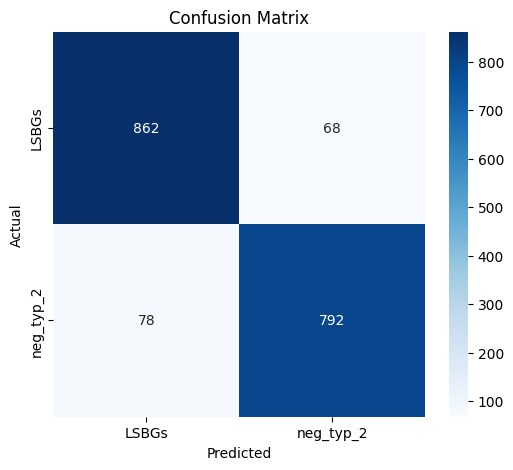

Classification Report:
               precision    recall  f1-score   support

       LSBGs       0.92      0.93      0.92       930
   neg_typ_2       0.92      0.91      0.92       870

    accuracy                           0.92      1800
   macro avg       0.92      0.92      0.92      1800
weighted avg       0.92      0.92      0.92      1800



In [18]:
evaluate_model(model, test_loader)